In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import pymaster as nmt
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps

In [104]:
plot_dir = '../plots/2023-01-25_figures'
save = True

In [24]:
NSIDE = 64
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

Area per pixel: 0.839 deg


In [28]:
def get_map(ras, decs):
    map_nqso, _ = maps.get_map(NSIDE, ras, decs, null_val=0)
    map_ndens = map_nqso/area_per_pixel
    map_ndens_masked = hp.ma(map_ndens)
    map_ndens_masked.mask = map_ndens==0
    return map_ndens_masked

## SDSS DR16Q

In [2]:
fn_sdss_full = '../data/SDSS_DR16Q_v4.fits'
tab_sdss_full = Table.read(fn_sdss_full, format='fits')

In [86]:
for c in sorted(tab_sdss_full.columns):
    print(c)

2RXS_DEC
2RXS_ID
2RXS_RA
2RXS_SRC_FLUX
2RXS_SRC_FLUX_ERR
AI_CIV
AI_SIIV
ANCILLARY_TARGET1
ANCILLARY_TARGET2
AUTOCLASS_DR14Q
AUTOCLASS_PQN
BAL_PROB
BI_CIV
BI_SIIV
BOSS_TARGET1
CAMCOL_NUMBER
CHUNK
CLASS_PERSON
CONF_DLA
DEC
DELTACHI2_CIII
DELTACHI2_CIV
DELTACHI2_HALPHA
DELTACHI2_HBETA
DELTACHI2_LYA
DELTACHI2_MGII
DELTACHI2_PCA
EBOSS_TARGET0
EBOSS_TARGET1
EBOSS_TARGET2
ERR_AI_CIV
ERR_AI_SIIV
ERR_BI_CIV
ERR_BI_SIIV
EXTINCTION
FIBERID
FIBERID_DUPLICATE
FIELD_NUMBER
FIRST_FLUX
FIRST_MATCHED
FIRST_SNR
FUV
FUV_IVAR
GAIA_BP_FLUX_SNR
GAIA_BP_MAG
GAIA_DEC
GAIA_DESIGNATION
GAIA_G_FLUX_SNR
GAIA_G_MAG
GAIA_MATCHED
GAIA_PARALLAX
GAIA_PARALLAX_ERR
GAIA_PM_DEC
GAIA_PM_DEC_ERR
GAIA_PM_RA
GAIA_PM_RA_ERR
GAIA_RA
GAIA_RP_FLUX_SNR
GAIA_RP_MAG
GALEX_MATCHED
HFLUX
HFLUX_ERR
HMAG
HMAG_ERR
HRDFLAG
HSNR
ID_NUMBER
IS_QSO_10K
IS_QSO_DR12Q
IS_QSO_DR7Q
IS_QSO_FINAL
IS_QSO_QN
JFLUX
JFLUX_ERR
JMAG
JMAG_ERR
JRDFLAG
JSNR
KFLUX
KFLUX_ERR
KMAG
KMAG_ERR
KRDFLAG
KSNR
LAMBDA_EFF
MJD
MJD_DUPLICATE
M_I
NHI_DLA
NSPEC
NSPEC_BOSS


In [5]:
# https://www.sdss4.org/dr16/algorithms/bitmasks/#ZWARNING
set(tab_sdss_full['ZWARNING'])

{-1, 0, 4, 64, 68}

In [6]:
idx_zwarn0 = tab_sdss_full['ZWARNING']==0
print(np.sum(idx_zwarn0), len(idx_zwarn0), np.sum(idx_zwarn0)/len(idx_zwarn0))

638022 750414 0.8502266748754688


In [40]:
map_ndens_sdss_masked = get_map(tab_sdss_full['RA'], tab_sdss_full['DEC'])

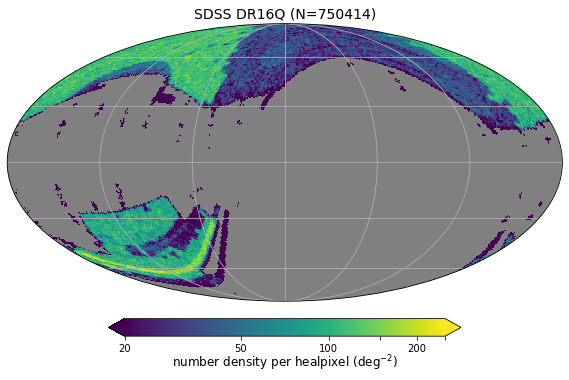

In [72]:
projview(map_ndens_sdss_masked, title=rf"SDSS DR16Q ($N={len(tab_sdss_full)}$)",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap='viridis', coord=['C', 'G'], 
            min=20, max=250, norm='log', graticule=True,
           show_tickmarkers=True, cbar_ticks=[20, 50, 100, 200, 500])

In [111]:
idx_hasg = np.isfinite(tab_sdss_full['PSFMAG'][:,1])
stats_idx(idx_hasg)

750414 750414 1.000


In [112]:
# TODO: need to convert g->G??
idx_gcut = tab_sdss_full['PSFMAG'][:,1] < 20.4
stats_idx(idx_gcut)

236035 750414 0.315


In [113]:
map_ndens_sdss_gcut_masked = get_map(tab_sdss_full['RA'][idx_gcut], tab_sdss_full['DEC'][idx_gcut])

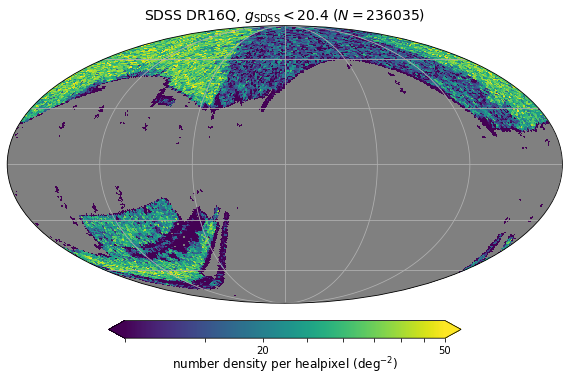

In [114]:
projview(map_ndens_sdss_gcut_masked, title=rf"SDSS DR16Q, $g_\mathrm{{SDSS}}<20.4$ ($N={len(tab_sdss_full[idx_gcut])}$)",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap='viridis', coord=['C', 'G'], 
            min=10, max=50, norm='log', graticule=True,
           show_tickmarkers=True, cbar_ticks=[20, 50, 100, 200, 500])
fn = f'{plot_dir}/sdss_qsos_20.4_2d.png'
if save:
    plt.savefig(fn)

## WISE+PS

In [17]:
fn_wiseps = '/scratch/ksf293/gaia-quasars-lss/data/PS1_WISE_QSO_photoz_catalog.csv'
tab_wiseps = Table.read(fn_wiseps, converters={'EXT': bool})

In [53]:
print(len(tab_wiseps))
idx_reliable = tab_wiseps['EXT']==False
print(np.sum(idx_reliable))

4849634
2879298


Great, matches abstract numbers! 

In [22]:
tab_wiseps.columns

<TableColumns names=('objID_PS1','raMean','decMean','w1mpro','w1sigmpro','w1mag','w1sigm','w2mpro','w2sigmpro','w2mag','w2sigm','gFPSFMag','gFPSFMagErr','gFKronMag','gFKronMagErr','rFPSFMag','rFPSFMagErr','rFKronMag','rFKronMagErr','iFPSFMag','iFPSFMagErr','iFKronMag','iFKronMagErr','zFPSFMag','zFPSFMagErr','zFKronMag','zFKronMagErr','yFPSFMag','yFPSFMagErr','yFKronMag','yFKronMagErr','EBV_PS1','EXT','z_pred_mean','z_pred_std','spectroz')>

In [42]:
map_ndens_wiseps_masked = get_map(tab_wiseps['raMean'], tab_wiseps['decMean'])

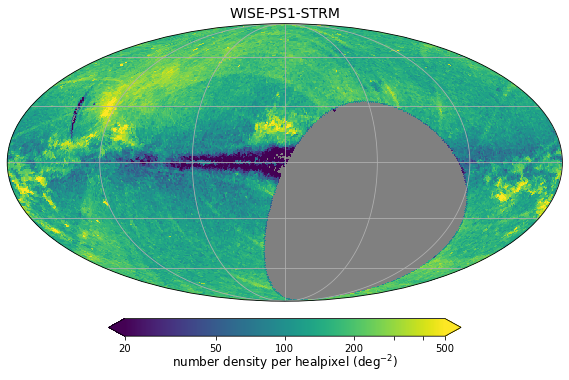

In [71]:
projview(map_ndens_wiseps_masked, title=rf"WISE-PS1-STRM ($N={len(tab_wiseps)}$)",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap='viridis', coord=['C', 'G'], 
            min=20, max=500, norm='log', graticule=True,
           show_tickmarkers=True, cbar_ticks=[20, 50, 100, 200, 500])

In [78]:
def stats_idx(idx):
    print(np.sum(idx), len(idx), f'{np.sum(idx)/len(idx):.3f}')

In [115]:
idx_gcut = tab_wiseps['gFPSFMag'] < 20.4
stats_idx(idx_gcut)

776703 4849634 0.160


In [116]:
map_ndens_wiseps_gcut_masked = get_map(tab_wiseps['raMean'][idx_gcut], tab_wiseps['decMean'][idx_gcut])

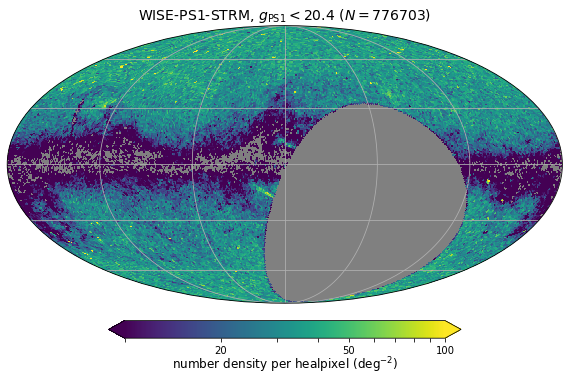

In [117]:
projview(map_ndens_wiseps_gcut_masked, title=rf"WISE-PS1-STRM, $g_\mathrm{{PS1}} < 20.4$ ($N={len(tab_wiseps[idx_gcut])}$)",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap='viridis', coord=['C', 'G'], 
            min=10, max=100, norm='log', graticule=True,
           show_tickmarkers=True, cbar_ticks=[20, 50, 100, 200, 500])
fn = f'{plot_dir}/wiseps_qsos_20.4_2d.png'
if save:
    plt.savefig(fn)

In [44]:
idx_has_specz = tab_wiseps['spectroz']!=-999
print(np.sum(idx_has_specz))

328677


In [67]:
def print_z_err_info(zs, zs_withspec, zs_spec):
    print(f"Median z: {np.median(zs):.3f}")
    
    threshs = [0.01, 0.1, 0.2, 0.5]
    dz = (zs_withspec - zs_spec)/(1 + zs_spec)
    n_tot = len(zs_spec)
    for thresh in threshs:
        n_below = np.sum(np.abs(dz) < thresh)
        print(fr'$f(|dz|<{thresh}) = {n_below/n_tot:.3f}$')

In [68]:
print_z_err_info(tab_wiseps['z_pred_mean'], 
                 tab_wiseps['z_pred_mean'][idx_has_specz], 
                 tab_wiseps['spectroz'][idx_has_specz])

Median z: 1.599
$f(|dz|<0.01) = 0.108$
$f(|dz|<0.1) = 0.706$
$f(|dz|<0.2) = 0.876$
$f(|dz|<0.5) = 0.982$


In [69]:
print_z_err_info(tab_wiseps['z_pred_mean'][idx_reliable], 
                 tab_wiseps['z_pred_mean'][idx_reliable&idx_has_specz], 
                 tab_wiseps['spectroz'][idx_reliable&idx_has_specz])

Median z: 1.411
$f(|dz|<0.01) = 0.110$
$f(|dz|<0.1) = 0.711$
$f(|dz|<0.2) = 0.880$
$f(|dz|<0.5) = 0.983$
